
# P9 — Baseline classique : PyRadiomics + (LogReg / Linear SVM)

**But :** établir une baseline *non neuronale*, robuste et interprétable, à partir de **features radiomiques** (PyRadiomics) extraites des tuiles histologiques, puis classifiées par un **modèle linéaire**.

**Points clés :**
- Reprend la logique du notebook CNN : variables de config, sampling équilibré, timing, artefacts.
- Compatible avec l'exécution **depuis `notebooks/`** (Docker), avec chemins robustes.
- Sauvegardes : `artifacts/` (par défaut) ou `models/` (sous la racine du projet).
- Sorties : classification report, **matrice de confusion**, temps d'entraînement, fichiers `.parquet` (features) et `.joblib` (modèle).


In [1]:
# ============================
# 🔧 CONFIG GLOBALE
# ============================
import os, sys, time, json
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
import pandas as pd
from tqdm.auto import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# ============================
# 🔧 CONFIG GLOBALE
# ============================
import os, sys, time, json
from pathlib import Path

# --- Emplacement du projet quand on lance depuis notebooks/ ---
PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
DATAGENERATOR_PATH = PROJECT_ROOT / "p9dg"

# Dossiers globaux du projet
MODELS_DIR      = PROJECT_ROOT / "models"
ARTIFACTS_DIR   = PROJECT_ROOT / "artifacts"
SAMPLES_DIR     = PROJECT_ROOT / "samples"     / "03_baseline_radiomics"
OUTPUTS_DIR     = PROJECT_ROOT / "outputs"     / "03_baseline_radiomics"
CHECKPOINTS_DIR = PROJECT_ROOT / "checkpoints" / "03_baseline_radiomics"
RUNS_DIR        = PROJECT_ROOT / "runs"        / "03_baseline_radiomics"
DATA_ROOT       = Path(os.getenv("DATA_ROOT", PROJECT_ROOT / "data")).resolve()
CONFIG_DIR      = Path(os.getenv("CONFIG_DIR", PROJECT_ROOT / "configs")).resolve()

for d in [MODELS_DIR, ARTIFACTS_DIR, SAMPLES_DIR, OUTPUTS_DIR, CHECKPOINTS_DIR, RUNS_DIR, CONFIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# --- Paramètres synchronisés avec le CNN notebook (02_baseline_cnn.ipynb) ---
IMAGE_SIZE  = int(os.getenv("IMAGE_SIZE", "256"))  # Même que CNN: 256
VAHADANE_ENABLE = os.getenv("VAHADANE_ENABLE", "1") == "1"  # True par défaut (comme CNN)
PIXEL_RANGE = os.getenv("PIXEL_RANGE", "imagenet")  # Même que CNN: "imagenet"
SAMPLES_PER_CLASS       = int(os.getenv("SAMPLES_PER_CLASS", "300"))   # Même que CNN: 300
SAMPLES_PER_CLASS_TEST  = max(5, SAMPLES_PER_CLASS // 5)               # Calculé: 60

# Les features radiomiques vont dans ARTIFACTS_DIR, les modèles dans MODELS_DIR
FEATURES_DIR = ARTIFACTS_DIR  # Pour les fichiers .parquet de features
SAVE_DIR = MODELS_DIR         # Pour les modèles .joblib

print(f"PROJECT_ROOT = {PROJECT_ROOT}")
print(f"DATA_ROOT    = {DATA_ROOT}")
print(f"CONFIG_DIR   = {CONFIG_DIR}")
print(f"FEATURES_DIR = {FEATURES_DIR}")
print(f"MODELS_DIR   = {MODELS_DIR}")
print(f"IMAGE_SIZE   = {IMAGE_SIZE} | VAHADANE_ENABLE={VAHADANE_ENABLE} | PIXEL_RANGE={PIXEL_RANGE}")


PROJECT_ROOT = /workspace
DATA_ROOT    = /workspace/data
CONFIG_DIR   = /workspace/configs
FEATURES_DIR = /workspace/artifacts
MODELS_DIR   = /workspace/models
IMAGE_SIZE   = 256 | VAHADANE_ENABLE=True | PIXEL_RANGE=imagenet


In [3]:

# ============================
# 📦 DÉPENDANCES
# ============================
import importlib

def _ensure(pkg, pip_name=None):
    try:
        return importlib.import_module(pkg)
    except Exception:
        print(f"⚠️ Le package '{pkg}' n'est pas importable. "
              f"Installez-le dans votre image Docker (ex: pip install {pip_name or pkg}).")
        return None

sitk = _ensure("SimpleITK", "SimpleITK")
pyrad = _ensure("radiomics", "pyradiomics")

# Nota : On n'exécute pas de pip install ici, car le notebook tourne dans Docker.

In [4]:

# ============================
# 🧬 DATAGENERATOR (réutilisation HistoDataset)
# ============================
# Utiliser DATAGENERATOR_PATH défini dans la cellule précédente
if "DATAGENERATOR_PATH" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    DATAGENERATOR_PATH = PROJECT_ROOT / "p9dg"

# Vérifie et ajoute au PYTHONPATH
if str(DATAGENERATOR_PATH) not in sys.path:
    sys.path.append(str(DATAGENERATOR_PATH))

# Import du dataset
from histo_dataset import HistoDataset

print(f"✅ Module histo_dataset importé depuis : {DATAGENERATOR_PATH}")


✅ Module histo_dataset importé depuis : /workspace/p9dg


In [5]:
# ============================
# 🧬 DATASET (réutilisation HistoDataset)
# ============================
# Utiliser DATA_ROOT, CONFIG_DIR et DEVICE définis dans les cellules précédentes
if "DATA_ROOT" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    DATA_ROOT = Path(os.getenv("DATA_ROOT", PROJECT_ROOT / "data")).resolve()
if "CONFIG_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    CONFIG_DIR = Path(os.getenv("CONFIG_DIR", PROJECT_ROOT / "configs")).resolve()
if "DEVICE" not in globals():
    import torch
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- TRAIN : sampling équilibré intégré au DataGenerator ---
ds_train = HistoDataset(
    root_data=str(DATA_ROOT),
    split="train",
    output_size=IMAGE_SIZE,
    pixel_range=PIXEL_RANGE,
    balance_per_class=True,                    # important
    apply_quality_filter=True,                 # Même que CNN
    samples_per_class_per_epoch=SAMPLES_PER_CLASS,
    thresholds_json_path=str(CONFIG_DIR / "seuils_par_classe.json"),
    vahadane_enable=VAHADANE_ENABLE,
    vahadane_target_path=str(DATA_ROOT / "NCT-CRC-HE-100K/TUM/TUM-ANVGTFCR.tif"),  # Même que CNN
    vahadane_device=DEVICE,
)

# --- TEST : pas de repeat -> on fabrique un sous-ensemble équilibré à partir des chemins
ds_test_full = HistoDataset(
    root_data=str(DATA_ROOT),
    split="test",
    output_size=IMAGE_SIZE,
    pixel_range=PIXEL_RANGE,
    balance_per_class=False,                   # pas utile en test
    apply_quality_filter=False,                # Pas de filtre en test (comme CNN val)
    thresholds_json_path=str(CONFIG_DIR / "seuils_par_classe.json"),
    vahadane_enable=VAHADANE_ENABLE,
    vahadane_target_path=str(DATA_ROOT / "NCT-CRC-HE-100K/TUM/TUM-ANVGTFCR.tif"),  # Même que CNN
    vahadane_device=DEVICE,
)

print("Classes (train):", ds_train.class_counts())
print("Classes (test) :", ds_test_full.class_counts())

# --- Récupérer la liste de chemins correspondant à l'epoch TRAIN courant (échantillonnage intégré)
def epoch_sample_paths(ds):
    # ds._epoch_indices est construit avec samples_per_class_per_epoch si balance_per_class=True
    seen = set()
    rows = []
    for ci, j in ds._epoch_indices:
        p = ds.paths_by_class[ci][j]
        if p in seen:
            continue
        seen.add(p)
        rows.append({"path": p, "label": ds.idx_to_class[ci]})
    return pd.DataFrame(rows)

df_train = epoch_sample_paths(ds_train)

# --- TEST : sous-échantillon équilibré (SAMPLES_PER_CLASS_TEST par classe)
def balanced_subset_from_paths(ds, per_class):
    rows = []
    for cls, ci in ds.class_to_idx.items():
        take = ds.paths_by_class[ci][:per_class]
        rows += [{"path": p, "label": cls} for p in take]
    return pd.DataFrame(rows)

df_test = balanced_subset_from_paths(ds_test_full, SAMPLES_PER_CLASS_TEST)

print(f"Train subset: {len(df_train)} | Test subset: {len(df_test)}")
df_train.head(), df_test.head()


🎨 Référence Vahadane fixée : TUM-ANVGTFCR.tif
✅ Seuils par classe chargés depuis : /workspace/configs/seuils_par_classe.json
⚖️ Échantillonnage équilibré activé (300 images / classe).
🎨 Référence Vahadane fixée : TUM-ANVGTFCR.tif
✅ Seuils par classe chargés depuis : /workspace/configs/seuils_par_classe.json
📂 Jeu complet (aucun sous-échantillonnage).
Classes (train): {'ADI': 10407, 'BACK': 10566, 'DEB': 11512, 'LYM': 11557, 'MUC': 8896, 'MUS': 13536, 'NORM': 8763, 'STR': 10446, 'TUM': 14317}
Classes (test) : {'ADI': 1338, 'BACK': 847, 'DEB': 339, 'LYM': 634, 'MUC': 1035, 'MUS': 592, 'NORM': 741, 'STR': 421, 'TUM': 1233}
Train subset: 2664 | Test subset: 540


(                                                path label
 0  /workspace/data/NCT-CRC-HE-100K/MUS/MUS-QWPCIF...   MUS
 1  /workspace/data/NCT-CRC-HE-100K/LYM/LYM-HLVTVF...   LYM
 2  /workspace/data/NCT-CRC-HE-100K/MUS/MUS-LPDCSL...   MUS
 3  /workspace/data/NCT-CRC-HE-100K/MUC/MUC-HENTVH...   MUC
 4  /workspace/data/NCT-CRC-HE-100K/ADI/ADI-ICASGA...   ADI,
                                                 path label
 0  /workspace/data/CRC-VAL-HE-7K/ADI/ADI-TCGA-SPA...   ADI
 1  /workspace/data/CRC-VAL-HE-7K/ADI/ADI-TCGA-HER...   ADI
 2  /workspace/data/CRC-VAL-HE-7K/ADI/ADI-TCGA-NDA...   ADI
 3  /workspace/data/CRC-VAL-HE-7K/ADI/ADI-TCGA-KLY...   ADI
 4  /workspace/data/CRC-VAL-HE-7K/ADI/ADI-TCGA-HHG...   ADI)

In [6]:
# ============================
# 🧮 Extraction radiomique robuste pour tuiles RGB (classification)
# ============================
from radiomics import featureextractor
import SimpleITK as sitk
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import logging
logging.getLogger("radiomics").setLevel(logging.ERROR)

# ============================================================
# ⚙️ Configuration PyRadiomics OPTIMISÉE
# ============================================================
# Optimisations pour améliorer la discrimination des classes histopathologiques :
# 1. binWidth réduit (10 au lieu de 25) pour une meilleure résolution de texture
# 2. Plus de distances GLCM pour capturer différentes échelles de texture
# 3. Plus de filtres d'images pour extraire différentes caractéristiques
# 4. Plus de classes de features pour une description plus riche

settings = {
    "binWidth": 15,  # ✅ Réduit de 25 à 10 pour meilleure résolution texture
    "resampledPixelSpacing": None,   # pas de resampling
    "interpolator": "sitkBSpline",
    "verbose": False,
    "force2D": True,
    "force2Ddimension": 0,           # pour images 2D
    "symmetricalGLCM": True,
    "distances": [1, 2, 3, 4, 5],   # ✅ Augmenté : plus d'échelles de texture
    "label": 1,                      # ROI = pixels == 1
}

extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
extractor.disableAllImageTypes()

# ✅ Plus de types d'images pour capturer différentes caractéristiques
extractor.enableImageTypeByName("Original")
extractor.enableImageTypeByName("LoG", {"sigma": [0.5, 1.0, 2.0, 3.0]})  # , 4.0, 5.0✅ Plus de sigmas
extractor.enableImageTypeByName("Wavelet")  # ✅ Transformée en ondelettes (décompose fréquences)
extractor.enableImageTypeByName("Square")   # ✅ Amplifie les contrastes
# extractor.enableImageTypeByName("SquareRoot")  # ✅ Réduit l'impact des valeurs élevées
extractor.enableImageTypeByName("Logarithm")   # ✅ Compression logarithmique
# extractor.enableImageTypeByName("Exponential") # ✅ Amplification exponentielle
extractor.enableImageTypeByName("Gradient")    # ✅ Détecte les bords

extractor.disableAllFeatures()

# ✅ Plus de classes de features pour une description plus complète
extractor.enableFeatureClassByName("firstorder")  # Statistiques de base (moyenne, écart-type, etc.)
extractor.enableFeatureClassByName("glcm")        # Matrice de co-occurrence (texture)
extractor.enableFeatureClassByName("glszm")       # Zone de taille de gris (texture)
extractor.enableFeatureClassByName("glrlm")       # ✅ Longueur de run de gris (texture directionnelle)
extractor.enableFeatureClassByName("ngtdm")       # ✅ Différence de ton de voisinage (texture fine)
extractor.enableFeatureClassByName("gldm")        # ✅ Matrice de dépendance de gris (texture)

# ============================================================
# 🧩 Fonctions utilitaires
# ============================================================

def _read_rgb_channels(path):
    """Lit une image RGB et renvoie les 3 canaux séparés (Float32)."""
    img_rgb = sitk.ReadImage(path)
    if img_rgb.GetNumberOfComponentsPerPixel() != 3:
        raise ValueError(f"L'image {path} n'est pas RGB (composants={img_rgb.GetNumberOfComponentsPerPixel()})")
    # Sépare les 3 canaux
    channels = [sitk.VectorIndexSelectionCast(img_rgb, i) for i in range(3)]
    channels = [sitk.Cast(ch, sitk.sitkFloat32) for ch in channels]
    return channels  # [img_R, img_G, img_B]


def _full_mask_with_border(img):
    """Masque tout à 1 sauf un bord à 0 pour éviter le bug PyRadiomics."""
    arr = np.ones(sitk.GetArrayFromImage(img).shape, dtype=np.uint32)
    arr[0, :] = 0
    arr[-1, :] = 0
    arr[:, 0] = 0
    arr[:, -1] = 0
    mask = sitk.GetImageFromArray(arr)
    mask.CopyInformation(img)
    return mask

def _to_3d_if_needed(img):
    """Convertit une image 2D en 3D (Z=1) pour compatibilité PyRadiomics."""
    if img.GetDimension() == 2:
        arr = sitk.GetArrayFromImage(img)[None, ...]  # (1, H, W)
        out = sitk.GetImageFromArray(arr)
        out.SetSpacing((1.0, 1.0, 1.0))
        out.SetOrigin((0.0, 0.0, 0.0))
        out.SetDirection(np.eye(3).flatten())
        return out
    return img

# ============================================================
# 🧮 Extraction des features pour une image
# ============================================================

def extract_one_row(path, label_str, pbar=None):
    """Extrait les features radiomiques d'une tuile RGB sur chaque canal."""
    try:
        imgs_rgb = _read_rgb_channels(path)
        mask = _full_mask_with_border(imgs_rgb[0])

        row = {"label": label_str, "path": path}
        
        # Traitement des 3 canaux (R, G, B)
        for ch_idx, (ch, ch_name) in enumerate(zip(imgs_rgb, ["R", "G", "B"]), 1):
            if pbar:
                # Mise à jour du postfix pour afficher le canal en cours
                pbar.set_postfix({
                    "canal": ch_name, 
                    "fichier": Path(path).name[:25],
                    "progr": f"{ch_idx}/3"
                })
            
            img3d = _to_3d_if_needed(ch)
            mask3d = _to_3d_if_needed(mask)
            mask3d = sitk.Cast(mask3d, sitk.sitkUInt32)

            feats = extractor.execute(img3d, mask3d, label=1)
            for k, v in feats.items():
                if isinstance(v, (int, float)):
                    row[f"{ch_name}_{k}"] = float(v)

        return row

    except Exception as e:
        if pbar:
            pbar.set_postfix({"erreur": "⚠️", "fichier": Path(path).name[:25]})
        print(f"❌ Erreur sur {path}: {e}")
        return {"label": label_str, "path": path}


# ============================================================
# 🗂️ Extraction pour un DataFrame complet
# ============================================================

def extract_df(df_paths, tag: str):
    results = []
    total_images = len(df_paths)
    
    # Barre de progression principale (images)
    pbar = tqdm(total=total_images, 
                desc=f"📊 Extract {tag}", 
                unit="img", 
                bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}] {postfix}')
    
    for idx, r in df_paths.iterrows():
        row = extract_one_row(r['path'], r['label'], pbar=pbar)
        results.append(row)
        # Mise à jour complète après chaque image (les 3 canaux sont traités)
        pbar.update(1)
    
    pbar.close()
    
    print(f"✅ Extraction terminée : {len(results)} images traitées")
    
    # Nettoyage et construction du DataFrame
    print("🧹 Nettoyage des données...")
    df = pd.DataFrame(results).replace([np.inf, -np.inf], np.nan)
    num_cols = [c for c in df.columns if c not in ("label", "path")]
    keep = [c for c in num_cols if not df[c].isna().all()]
    print(f"✅ {len(keep)} features valides sur {len(num_cols)} extraites")
    
    return pd.concat([df[["label", "path"]], df[keep]], axis=1)

# ============================================================
# 🚀 Exécution sur train/test
# ============================================================

print("=" * 70)
print("🚀 DÉBUT DE L'EXTRACTION RADIOMIQUE")
print("=" * 70)
print(f"📊 Configuration:")
print(f"   - Images train: {len(df_train)}")
print(f"   - Images test:  {len(df_test)}")
print(f"   - Types d'images: Original, LoG, Wavelet, Square, SquareRoot, Logarithm, Exponential, Gradient")
print(f"   - Classes de features: firstorder, glcm, glszm, glrlm, ngtdm, gldm")
print(f"   - binWidth: {settings['binWidth']}")
print(f"   - Distances GLCM: {settings['distances']}")
print("=" * 70)
print()

# Extraction train
print("📈 EXTRACTION TRAIN")
print("-" * 70)
df_feats_train = extract_df(df_train, "train")
print()

# Extraction test
print("📈 EXTRACTION TEST")
print("-" * 70)
df_feats_test  = extract_df(df_test,  "test")
print()

# Résumé final
print("=" * 70)
print("✅ EXTRACTION TERMINÉE")
print("=" * 70)
n_feats_train = len([c for c in df_feats_train.columns if c not in ("label", "path")])
n_feats_test = len([c for c in df_feats_test.columns if c not in ("label", "path")])
print(f"📊 Features extraites:")
print(f"   - Train: {n_feats_train} features pour {len(df_feats_train)} images")
print(f"   - Test:  {n_feats_test} features pour {len(df_feats_test)} images")
print("=" * 70)

# ============================================================
# 💾 Sauvegarde
# ============================================================
# Utiliser FEATURES_DIR défini dans la cellule précédente (ARTIFACTS_DIR pour les features)
if "FEATURES_DIR" not in globals():
    if "ARTIFACTS_DIR" not in globals():
        if "PROJECT_ROOT" not in globals():
            PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
        ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
    FEATURES_DIR = ARTIFACTS_DIR
FEATURES_DIR.mkdir(parents=True, exist_ok=True)

train_parquet = FEATURES_DIR / "radiomics_train.parquet"
test_parquet  = FEATURES_DIR / "radiomics_test.parquet"

df_feats_train.to_parquet(train_parquet, index=False)
df_feats_test.to_parquet(test_parquet, index=False)

print(f"✅ Sauvegardé: {train_parquet}")
print(f"✅ Sauvegardé: {test_parquet}")


🚀 DÉBUT DE L'EXTRACTION RADIOMIQUE
📊 Configuration:
   - Images train: 2664
   - Images test:  540
   - Types d'images: Original, LoG, Wavelet, Square, SquareRoot, Logarithm, Exponential, Gradient
   - Classes de features: firstorder, glcm, glszm, glrlm, ngtdm, gldm
   - binWidth: 15
   - Distances GLCM: [1, 2, 3, 4, 5]

📈 EXTRACTION TRAIN
----------------------------------------------------------------------


📊 Extract train:   0%|          | 0/2664 [00:00<?, ?img/s] 

✅ Extraction terminée : 2664 images traitées
🧹 Nettoyage des données...
✅ 15 features valides sur 15 extraites

📈 EXTRACTION TEST
----------------------------------------------------------------------


📊 Extract test:   0%|          | 0/540 [00:00<?, ?img/s] 

✅ Extraction terminée : 540 images traitées
🧹 Nettoyage des données...
✅ 15 features valides sur 15 extraites

✅ EXTRACTION TERMINÉE
📊 Features extraites:
   - Train: 15 features pour 2664 images
   - Test:  15 features pour 540 images
✅ Sauvegardé: /workspace/artifacts/radiomics_train.parquet
✅ Sauvegardé: /workspace/artifacts/radiomics_test.parquet


Avec un masque plein on a les features de premier ordre :
- original_firstorder_Mean
- original_firstorder_Std
- original_firstorder_Kurtosis
- original_firstorder_Skewness
- original_firstorder_Entropy


=== Résumé comparatif ===
 Model  Accuracy  Recall_TUM  Train_time_s
    RF  0.533333    0.616667      0.209862
LogReg  0.498148    0.716667      0.825363
LinSVM  0.451852    0.666667      0.034217

🏆 Meilleur modèle: RF
→ Accuracy globale: 0.533
→ Recall sur TUM : 0.617

=== Rapport de classification (meilleur modèle) ===
              precision    recall  f1-score   support

         ADI      0.964     0.900     0.931        60
        BACK      0.870     1.000     0.930        60
         DEB      0.519     0.450     0.482        60
         LYM      0.395     0.283     0.330        60
         MUC      0.737     0.700     0.718        60
         MUS      0.407     0.400     0.403        60
        NORM      0.324     0.200     0.247        60
         STR      0.333     0.250     0.286        60
         TUM      0.303     0.617     0.407        60

    accuracy                          0.533       540
   macro avg      0.539     0.533     0.526       540
weighted avg      0.539 

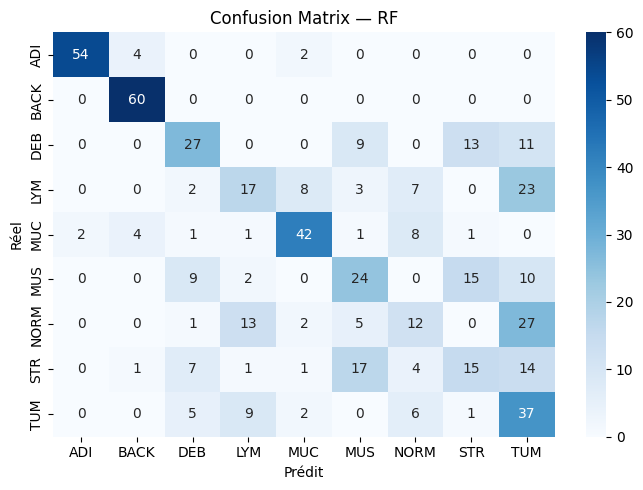

✅ Meilleur modèle sauvegardé: /workspace/models/radiomics_best_RF.joblib


In [7]:
# ============================
# 🤖 Mini-grid baseline — sélection du meilleur modèle (corrigée)
# ============================
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- Chargement features ---
# Utiliser FEATURES_DIR défini dans la cellule précédente
if "FEATURES_DIR" not in globals():
    if "ARTIFACTS_DIR" not in globals():
        if "PROJECT_ROOT" not in globals():
            PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
        ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"
    FEATURES_DIR = ARTIFACTS_DIR

if 'df_feats_train' not in globals():
    df_feats_train = pd.read_parquet(FEATURES_DIR / "radiomics_train.parquet")
if 'df_feats_test' not in globals():
    df_feats_test  = pd.read_parquet(FEATURES_DIR / "radiomics_test.parquet")

# =====================================================
# 🧹 Nettoyage et harmonisation
# =====================================================
def clean_numeric(df: pd.DataFrame, label_col="label"):
    df = df.copy()
    keep = [c for c in df.columns if c == label_col or c == "path" or np.issubdtype(df[c].dtype, np.number)]
    df = df[keep]
    df = df.replace([np.inf, -np.inf], np.nan)
    num_cols = [c for c in df.columns if c not in (label_col, "path")]
    non_all_nan = [c for c in num_cols if not df[c].isna().all()]
    df = pd.concat([df[[c for c in df.columns if c not in num_cols]], df[non_all_nan]], axis=1)
    return df, [c for c in df.columns if c not in (label_col, "path")]

df_feats_train, num_train_cols = clean_numeric(df_feats_train)
df_feats_test,  num_test_cols  = clean_numeric(df_feats_test)

common_cols = sorted(set(num_train_cols) & set(num_test_cols))
const_cols = [c for c in common_cols if df_feats_train[c].nunique(dropna=True) <= 1]
use_cols = [c for c in common_cols if c not in const_cols]

X_train = df_feats_train[use_cols].fillna(0.0).to_numpy(dtype=np.float64)
y_train = df_feats_train["label"].to_numpy()
X_test  = df_feats_test[use_cols].fillna(0.0).to_numpy(dtype=np.float64)
y_test  = df_feats_test["label"].to_numpy()
labels = sorted(np.unique(y_test))

# =====================================================
# 🧠 Mini-grid de classifieurs
# =====================================================
models = {
    "LogReg": LogisticRegression(
        penalty="l2", C=1.0, solver="saga", max_iter=4000,
        n_jobs=-1,  # multiclass deprecated
    ),
    "LinSVM": LinearSVC(C=1.0, max_iter=4000),
    "RF": RandomForestClassifier(
        n_estimators=200, max_depth=None, n_jobs=-1, random_state=42
    ),
}

results = []

for name, base_clf in models.items():
    steps = [
        ("varsel", VarianceThreshold(threshold=0.0)),
        ("scaler", StandardScaler(with_mean=False)),
        ("clf", base_clf)
    ]
    clf = Pipeline(steps)

    start = time.perf_counter()
    clf.fit(X_train, y_train)
    train_time_s = time.perf_counter() - start
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    # --- rapport complet pour extraire le recall sur TUM ---
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    recall_tum = report["TUM"]["recall"] if "TUM" in report else np.nan

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Recall_TUM": recall_tum,
        "Train_time_s": train_time_s,
        "y_pred": y_pred,
        "pipeline": clf,
        "report": report
    })

# =====================================================
# 🥇 Sélection du meilleur modèle
# =====================================================
df_results = pd.DataFrame(results).sort_values(by=["Accuracy", "Recall_TUM"], ascending=[False, False])
best = df_results.iloc[0]
best_name = best["Model"]
best_y_pred = best["y_pred"]
best_pipeline = best["pipeline"]
best_report = best["report"]

print("\n=== Résumé comparatif ===")
print(df_results[["Model", "Accuracy", "Recall_TUM", "Train_time_s"]].to_string(index=False))

print(f"\n🏆 Meilleur modèle: {best_name}")
print(f"→ Accuracy globale: {best['Accuracy']:.3f}")
print(f"→ Recall sur TUM : {best['Recall_TUM']:.3f}")

# =====================================================
# 📊 Rapport et matrice de confusion du meilleur
# =====================================================
print("\n=== Rapport de classification (meilleur modèle) ===")
print(classification_report(y_test, best_y_pred, digits=3, zero_division=0))

cm = confusion_matrix(y_test, best_y_pred, labels=labels)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title(f"Confusion Matrix — {best_name}")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

# =====================================================
# 💾 Sauvegarde du meilleur modèle
# =====================================================
# Utiliser MODELS_DIR défini dans la cellule précédente
if "MODELS_DIR" not in globals():
    if "PROJECT_ROOT" not in globals():
        PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT", "..")).resolve()
    MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

model_path = MODELS_DIR / f"radiomics_best_{best_name}.joblib"
joblib.dump({
    "pipeline": best_pipeline,
    "labels": labels,
    "train_time_s": best["Train_time_s"],
    "use_cols": use_cols
}, model_path)
print(f"✅ Meilleur modèle sauvegardé: {model_path}")



## Notes
- Si l'extraction PyRadiomics est **lente**, réduisez les familles de features (évitez `enableAllImageTypes` ou limitez les filtres).
- Vous pouvez activer `class_weight='balanced'` dans `LogisticRegression` ou ajuster `C`.
- Les datasets étant filtrés par `HistoDataset` (qualité + normalisation), cette baseline est directement comparable au CNN.
- Pour sauvegarder dans `models/`, lancez le notebook avec `SAVE_TO=models`.
